# Cart Pendulum

The cart pendulum is a simple device comprising of a pendulum attached to a movable cart. The cart in this example is capable of moving along the horizontal alone. 

In this notebook, the equations govenring the dynamics of this device will be derived using Lagrangian dynamics and the sympy package. Later, an LQR control will be implemented to maintain the vertical position of the pendulum

In [1]:
from ipywidgets import interact
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import sympy  as sp
import numpy as np
import control as ct
import control.matlab as ct_matlab



# Deriving the equations

We will derive the equations using Euler–Lagrange equation.

The Pendulum is assumed to be a mass at the end of a massless rod

The Variables 

x1 : Position of the cart

x2 : Angles of the pendulum measured from the -y axis

In [2]:
# Time
t  = sp.symbols('t')

# Time derivative
ddt = lambda x:sp.diff(x,t)

# States
x1   = sp.Function('x1')
x2   = sp.Function('x2')
x1d  = ddt(x1(t))
x2d  = ddt(x2(t))
x1dd = ddt(x1d)
x2dd = ddt(x2d)

# Control input variable
u   = sp.symbols('u')

# Parameters
m1, m2, l, g = sp.symbols('m1, m2, l, g')

# positions. Here c: cart, p: pendulum
cart_x   = x1(t)
cart_y   = 0
cart_pos = [cart_x, cart_y]

pendulum_x   =  l*sp.sin(x2(t)) + x1(t)
pendulum_y   = -l*sp.cos(x2(t))
pendulum_pos = [pendulum_x, pendulum_y]

# Velocities
cart_vel     = [ddt(i) for i in cart_pos]
pendulum_vel = [ddt(i) for i in pendulum_pos]

cart_v_squared     = sum(i**2 for i in cart_vel)
pendulum_v_squared = sum(i**2 for i in pendulum_vel)


#### Solving the Langrange equations

In [3]:

# Energies
# Potential energy
pe = -m2*g*pendulum_y

# Kinetic energy
ke = m1*cart_v_squared/2   +   m2*pendulum_v_squared/2

# Lagrangian
L = ke - pe

# The Differential equation
DEs = [
    ddt(sp.diff(L, x1d)) - sp.diff(L, x1(t)) - u, # Fully coupled
    # ddt(ddt(x1(t)))    - u,                     # When you dont want the dynamics of the pendulum to affect the cart
    ddt(sp.diff(L, x2d)) - sp.diff(L, x2(t))
]
DEs = [DE.simplify() for DE in DEs]

# Solving to get explicit values for the two state double derivatives
DEexplicit = sp.solve(DEs,           [x1dd, x2dd]) # Solving
DEexplicit = [DEexplicit[i] for i in [x1dd, x2dd]] # Extracting the solutions
DEexplicit = [DE.simplify() for DE in DEexplicit]  # Simplifying the solution

#### Substituting the state which are functions of time to plain symbols

In [4]:
y1, y2, y1d, y2d = sp.symbols('y1, y2, y1d, y2d')
substitutions = {
    x1(t): y1,
    x2(t): y2,

    ddt(x1(t)): y1d,
    ddt(x2(t)): y2d,
}

y1dd, y2dd    = [i.subs(substitutions) for i in DEexplicit]
y1dd_function = sp.lambdify((y1, y1d, y2, y2d, t, u, m1, m2, l, g), y1dd) 
y2dd_function = sp.lambdify((y1, y1d, y2, y2d, t, u, m1, m2, l, g), y2dd) 


# Simulating 

In [5]:
def get_PendulumCartRates(X, t, uf, m1, m2, l, g):
    X_ = X
    u  = uf(X_)
    x1, v1, x2, v2 = X_
    x1d = v1
    v1d = y1dd_function(x1, v1, x2, v2, t, u, m1, m2, l, g)
    x2d = v2
    v2d = y2dd_function(x1, v1, x2, v2, t, u, m1, m2, l, g)


    return np.array([x1d, v1d, x2d, v2d])

In [6]:
# System parameters
param_vals = {
    "m1" : 1,
    "m2" : 1,
    "g"  : -10,
    "l"  : 1
}

# No control law, free moving
control_no = lambda x:0 

# Simulation parameters
dt = 0.001
t0 = 0.0
tn = 10.0
ts = np.arange(t0, tn, dt)
t_step = [0.0, dt]

# Initial condition
x0 = np.array([0, 0, np.pi/2, 0])

# Integrate
result = odeint(
    get_PendulumCartRates, x0, ts, 
    args=(control_no, param_vals["m1"], param_vals["m2"], param_vals["l"], param_vals["g"])
    )

In [7]:
def animte_CartPend(result, ts):
    """
    Accepts cart state information and returns an animation
    """
    # Setting axes range
    x_range = [-3,   3]
    y_range = [-1.1, 1.1]
    delta   = lambda ls: ls[1] - ls[0]
    aspect  = (delta(x_range)) / (delta(y_range))

    # setting matplotlib parameters
    scale = 3
    plt.rcParams['figure.figsize'] = [aspect * scale, scale]
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['animation.html'] = 'jshtml'


    # Selecting the animation range
    res_plot = result[::50]
    ts_plot  = ts[::50]

    # Setting up the plot
    fig, ax     = plt.subplots()
    pend_plot,  = plt.plot([],[], 'o-', linewidth=2, ms=10, markerfacecolor='r')
    cart_plot,  = plt.plot([],[], 'ks', ms=10) 

    print(type(pend_plot))

    def init():
        ax.set_xlim(x_range[0], x_range[1])
        ax.set_ylim(y_range[0], y_range[1])
        ax.set_aspect('equal')

    def animate(iter):
        x_cart, _, th_pend, _ = res_plot[iter]
        sub_obs               = {x1(t): x_cart, x2(t): th_pend, l: param_vals["l"]}
        x_pend, y_pend        = [sp.N(i.subs(sub_obs)) for i in pendulum_pos]

        pend_plot.set_data([x_cart, x_pend],[0, y_pend])
        cart_plot.set_data([x_cart]        ,[0])

    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(res_plot), interval=50, blit=False, repeat=False)

<class 'matplotlib.lines.Line2D'>


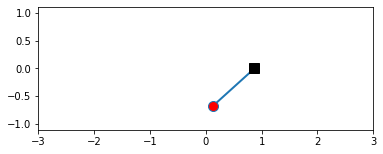

In [8]:

anim = animte_CartPend(result, ts)
HTML(anim.to_jshtml())
        

# Control

#### Linearizing the systems

In [9]:
# Storing the cumbersome partial derivative function in a lambda
ddx = lambda f,x:sp.diff(f,x)

# Defining variables to store rates of change
x1d_val,  x2d_val  = x1d, x2d
x1dd_val, x2dd_val = DEexplicit

# Storing states and their change in variables
Xs  = [x1(t),   x1d,      x2(t),   x2d]
Xds = [x1d_val, x1dd_val, x2d_val, x2dd_val]

#  the stationary point Substitution
subs_stationary = {
    x2(t)      : sp.pi,
    ddt(x2(t)) : 0,
    ddt(x1(t)) : 0
}

A_sp = sp.Matrix([ [  ddx(xd,x).simplify().subs(subs_stationary) for x in Xs]  for xd in Xds])
B_sp = sp.Matrix([ [  ddx(xd,u).simplify().subs(subs_stationary)]              for xd in Xds])

### LQR tuning

In [10]:
# The Parameters for substitution to get numerical values
param_subs = {
    m1 : param_vals["m1"],
    m2 : param_vals["m2"],
    g  : param_vals["g"],
    l  : param_vals["l"] 
}

# Matrices with numerical values
A_np  = np.array(A_sp.subs(param_subs))
B_np  = np.array(B_sp.subs(param_subs))
Q     = np.eye(4)
R     = 0.001

# Use the LQR algorithm 
K_np  = np.array(ct_matlab.lqr(A_np, B_np, Q, R)[0])

In [11]:

# Simulation parameters
dt = 0.001
t0 = 0.0
tn = 10.0
ts = np.arange(t0, tn, dt)
t_step = [0.0, dt]

# Initial condition
x0  = np.array([0, 0, np.pi-0.8, 0])

# Set point
xsp = np.array([0, 0, np.pi, 0])

# Controller function
control_law = lambda x: -(K_np @(x-xsp))[0]

# Integrate
res_ctrl = odeint(
    get_PendulumCartRates, x0, ts, 
    args=(control_law, param_vals["m1"], param_vals["m2"], param_vals["l"], param_vals["g"])
)


<class 'matplotlib.lines.Line2D'>


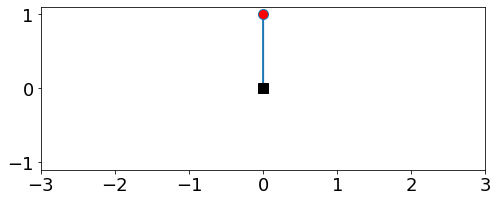

In [12]:
anim = animte_CartPend(res_ctrl, ts)
HTML(anim.to_jshtml())